# Ridge Regression and LASSO for Binary Classification

## By: Mustafa Yildirim

### Implementing the Ridge regression (both the closed-form solution and SGD) and compare it with the linear regression method in terms of convergence rate and/or classification accuracy in the binary classification task of digits ('7' and '9') in MNIST.



In [ ]:
# download MNIST data

!gdown --folder https://drive.google.com/drive/folders/1r20aRjc2iu9O3kN3Xj9jNYY2uMgcERY1 2> /dev/null

# install python_mnist

!pip install python_mnist

Processing file 1Jf2XqGR7y1fzOZNKLJiom7GmZZUzXhfs t10k-images-idx3-ubyte
Processing file 1qiYu9dW3ZNrlvTFO5fI4qf8Wtr8K-pCu t10k-labels-idx1-ubyte
Processing file 1SnWvBcUETRJ53rEJozFUUo-hOQFPKxjp train-images-idx3-ubyte
Processing file 1kKEIi_pwVHmabByAnwZQsaMgro9XiBFE train-labels-idx1-ubyte


In [ ]:
#load MINST images

from mnist import MNIST
import numpy as np

mnist_loader = MNIST('MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_label = np.array(test_label, dtype='short')

#add small random noise to avoid matrix singularity
train_data += np.random.normal(0,0.0001,train_data.shape)

print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [ ]:
# prepare digits '7' and '9' for linear regression

digit_train_index = np.logical_or(train_label == 7, train_label == 9)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 7, test_label == 9)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# add a constant column of '1' to accomodate the bias (see the margin note on page 107)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1), dtype=X_train.dtype)))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1), dtype=X_test.dtype)))

# convert labels: '7' => -1, '9' => +1
CUTOFF = 8 # any number between '7' and '9'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

print(X_train.shape)
print(y_train)

print(X_test.shape)
print(y_test)

(12214, 785)
[ 1 -1  1 ... -1  1  1]
(2037, 785)
[-1  1  1 ... -1 -1  1]


Ridge regression with closed-form solution



In [ ]:
lambda_reg = 0.1

w = np.linalg.inv(X_train.T @ X_train + lambda_reg * np.eye(X_train.shape[1])) @ X_train.T @ y_train

# calculate the mean square error and classification accuracy on the training set
predict = X_train @ w
error = np.sum((predict - y_train)*(predict - y_train))/X_train.shape[0]
print(f'mean square error on training data for the closed-form solution: {error:.5f}')

accuracy = np.count_nonzero(np.equal(np.sign(predict),y_train))/y_train.size*100.0
print(f'classification accuracy on training data for the closed-form solution: {accuracy:.2f}%')

# calculate the mean square error and classification accuracy on the test set
predict = X_test @ w
error = np.sum((predict - y_test)*(predict - y_test))/X_test.shape[0]
print(f'mean square error on test data for the closed-form solution: {error:.5f}')

accuracy = np.count_nonzero(np.equal(np.sign(predict),y_test))/y_test.size*100.0
print(f'classification accuracy on test data for the closed-form solution: {accuracy:.2f}%')

mean square error on training data for the closed-form solution: 0.20655
classification accuracy on training data for the closed-form solution: 96.36%
mean square error on test data for the closed-form solution: 0.24104
classification accuracy on test data for the closed-form solution: 95.88%


Ridge regression with SGD

In [ ]:
class Optimizer():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs, lambda_reg):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs
    self.lambda_reg = lambda_reg

def ridge_regression_gd(X, y, X2, y2, op):
  n = X.shape[0]   # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  errorsA = np.zeros(op.max_epochs)
  errorsB = np.zeros(op.max_epochs)
  errorsC = np.zeros(op.max_epochs)

  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices

    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]


      # vectorization to compute gradients for a whole mini-batch
      w_grad = X_batch.T @ X_batch @ w - X_batch.T @ y_batch + 2 * op.lambda_reg * w

      w -= lr * w_grad / X_batch.shape[0]

    # for learning curve C
    diff = X @ w - y  # prediction difference
    errorsC[epoch] = np.sum(diff*diff)/n

    # for learning curve A
    predict = np.sign(X @ w)
    errorsA[epoch] = np.count_nonzero(np.equal(predict,y))/y.size

    # for learning curve B
    predict2 = np.sign(X2 @ w)
    errorsB[epoch] = np.count_nonzero(np.equal(predict2,y2))/y2.size

    lr *= op.annealing_rate
    print(f'epoch={epoch}: the mean square error is {errorsC[epoch]:.3f} ({errorsA[epoch]:.3f},{errorsB[epoch]:.3f})')

  return w, errorsA, errorsB, errorsC


epoch=0: the mean square error is 0.463 (0.925,0.926)
epoch=1: the mean square error is 0.344 (0.931,0.934)
epoch=2: the mean square error is 0.308 (0.933,0.937)
epoch=3: the mean square error is 0.294 (0.936,0.942)
epoch=4: the mean square error is 0.285 (0.938,0.946)
epoch=5: the mean square error is 0.279 (0.940,0.946)
epoch=6: the mean square error is 0.275 (0.941,0.950)
epoch=7: the mean square error is 0.271 (0.942,0.948)
epoch=8: the mean square error is 0.268 (0.943,0.950)
epoch=9: the mean square error is 0.265 (0.944,0.950)
epoch=10: the mean square error is 0.263 (0.945,0.950)
epoch=11: the mean square error is 0.260 (0.945,0.951)
epoch=12: the mean square error is 0.259 (0.946,0.950)
epoch=13: the mean square error is 0.257 (0.946,0.951)
epoch=14: the mean square error is 0.255 (0.947,0.952)
epoch=15: the mean square error is 0.254 (0.948,0.953)
epoch=16: the mean square error is 0.253 (0.947,0.953)
epoch=17: the mean square error is 0.252 (0.949,0.955)
epoch=18: the mean s

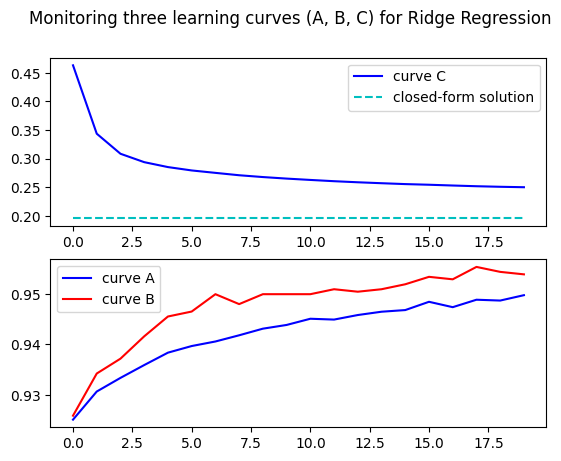

In [ ]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=50, max_epochs=20, lambda_reg = 0.1)

w, A, B, C = ridge_regression_gd(X_train, y_train, X_test, y_test, op)

fig, ax = plt.subplots(2)
fig.suptitle('Monitoring three learning curves (A, B, C) for Ridge Regression')
ax[0].plot(C, 'b', 0.196*np.ones(C.shape[0]), 'c--')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

Linear regression with closed-form solution from Lab 2 notebook

In [ ]:
# use the closed-form solution

# refer to the closed-form solution, i.e. Eq.(6.9) on page 112
w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

# calculate the mean square error and classification accuracy on the training set
predict = X_train @ w
error = np.sum((predict - y_train)*(predict - y_train))/X_train.shape[0]
print(f'mean square error on training data for the closed-form solution: {error:.5f}')

accuracy = np.count_nonzero(np.equal(np.sign(predict),y_train))/y_train.size*100.0
print(f'classification accuracy on training data for the closed-form solution: {accuracy:.2f}%')

# calculate the mean square error and classification accuracy on the test set
predict = X_test @ w
error = np.sum((predict - y_test)*(predict - y_test))/X_test.shape[0]
print(f'mean square error on test data for the closed-form solution: {error:.5f}')

accuracy = np.count_nonzero(np.equal(np.sign(predict),y_test))/y_test.size*100.0
print(f'classification accuracy on test data for the closed-form solution: {accuracy:.2f}%')

mean square error on training data for the closed-form solution: 0.20240
classification accuracy on training data for the closed-form solution: 96.53%
mean square error on test data for the closed-form solution: 0.83885
classification accuracy on test data for the closed-form solution: 95.88%


Linear regression with SGD from Lab 2 notebook

In [ ]:
# solve linear regression using gradient descent
class Optimizer():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs

# X[N,d]: training features; y[N]: training targets;
# X2[N,d]: test features; y2[N]: test targets;
# op: hyper-parameters for optimzer
#
# Note: X2 and y2 are not used in training
#       but only for computting the learning curve B
#
def linear_regression_gd2(X, y, X2, y2, op):
  n = X.shape[0]   # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  errorsA = np.zeros(op.max_epochs)
  errorsB = np.zeros(op.max_epochs)
  errorsC = np.zeros(op.max_epochs)

  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]

      # vectorization to compute gradients for a whole mini-batch (see the above formula)
      w_grad = X_batch.T @ X_batch @ w - X_batch.T @ y_batch

      w -= lr * w_grad / X_batch.shape[0]

    # for learning curve C
    diff = X @ w - y  # prediction difference
    errorsC[epoch] = np.sum(diff*diff)/n

    # for learning curve A
    predict = np.sign(X @ w)
    errorsA[epoch] = np.count_nonzero(np.equal(predict,y))/y.size

    # for learning curve B
    predict2 = np.sign(X2 @ w)
    errorsB[epoch] = np.count_nonzero(np.equal(predict2,y2))/y2.size

    lr *= op.annealing_rate
    print(f'epoch={epoch}: the mean square error is {errorsC[epoch]:.3f} ({errorsA[epoch]:.3f},{errorsB[epoch]:.3f})')

  return w, errorsA, errorsB, errorsC

epoch=0: the mean square error is 0.463 (0.924,0.927)
epoch=1: the mean square error is 0.344 (0.931,0.935)
epoch=2: the mean square error is 0.308 (0.933,0.939)
epoch=3: the mean square error is 0.294 (0.937,0.943)
epoch=4: the mean square error is 0.285 (0.939,0.945)
epoch=5: the mean square error is 0.279 (0.939,0.947)
epoch=6: the mean square error is 0.274 (0.941,0.947)
epoch=7: the mean square error is 0.271 (0.942,0.948)
epoch=8: the mean square error is 0.268 (0.942,0.949)
epoch=9: the mean square error is 0.265 (0.944,0.949)
epoch=10: the mean square error is 0.262 (0.944,0.950)
epoch=11: the mean square error is 0.260 (0.946,0.950)
epoch=12: the mean square error is 0.258 (0.946,0.950)
epoch=13: the mean square error is 0.257 (0.946,0.951)
epoch=14: the mean square error is 0.255 (0.948,0.951)
epoch=15: the mean square error is 0.254 (0.948,0.953)
epoch=16: the mean square error is 0.253 (0.948,0.953)
epoch=17: the mean square error is 0.251 (0.948,0.954)
epoch=18: the mean s

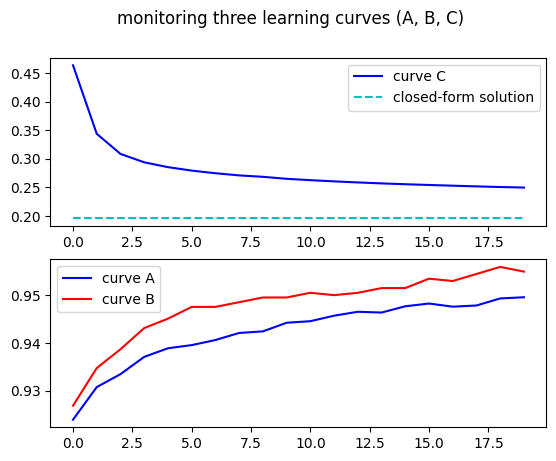

In [ ]:
op = Optimizer(lr=0.001, annealing_rate=0.99, batch_size=50, max_epochs=20)

w, A, B, C = linear_regression_gd2(X_train, y_train, X_test, y_test, op)

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, B, C)')
ax[0].plot(C, 'b', 0.196*np.ones(C.shape[0]), 'c--')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

### Implementing the SGD for LASSO and compare its solution with that of the linear regression method in the Boston House data set.



In [ ]:
# download boston house data from Google drive

!gdown --folder https://drive.google.com/drive/folders/12L9XNwhIH2wQBa4-IdQrhsrtgRFbeIMZ 2> /dev/null

Processing file 1IZf0tFGW3Zv3Ax5gxKgnklHe1DUI7CAI boston.csv


In [ ]:
# load Boston House data set
import pandas as pd
import numpy as np

raw_data = pd.read_csv('Boston/boston.csv', header=None)
data_rows = np.reshape(raw_data.to_numpy(), (506,14))
data = data_rows[:,:13]
target = data_rows[:,13]

# normalize input features to zero-mean and unit-variance
data = (data-np.mean(data, axis=0))/np.std(data, axis=0)

print(data.shape)
print(target.shape)

(506, 13)
(506,)


In [ ]:
data_wb = np.hstack((data, np.ones((data.shape[0], 1), dtype=data.dtype)))

print(data_wb.shape)

(506, 14)


LASSO with SGD

In [ ]:
# solve LASSO using gradient descent
class OptimizerLas():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs, lambda_reg):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs
    self.lambda_reg = lambda_reg


# X[N,d]: input features; y[N]: output targets; op: hyper-parameters for optimzer
def LASSO_gd(X, y, op):
  n = X.shape[0]   # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  errors = np.zeros(op.max_epochs)
  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]


      # vectorization to compute gradients for a whole mini-batch
      w_grad = X_batch.T @ X_batch @ w - X_batch.T @ y_batch + op.lambda_reg * np.sign(w)

      w -= lr * w_grad / X_batch.shape[0]

    diff = X @ w - y  # prediction difference
    errors[epoch] = np.sum(diff*diff)/n
    lr *= op.annealing_rate
    print(f'epoch={epoch}: the mean square error is {errors[epoch]}')

  return w, errors

Displaying the MSE and accuracy (The graph is at the bottom)

epoch=0: the mean square error is 568.0756302436935
epoch=1: the mean square error is 545.9121513179657
epoch=2: the mean square error is 525.5186611693633
epoch=3: the mean square error is 506.4648021282687
epoch=4: the mean square error is 488.7876697063322
epoch=5: the mean square error is 472.21628240028224
epoch=6: the mean square error is 456.603722081787
epoch=7: the mean square error is 441.8612045929995
epoch=8: the mean square error is 427.9183217765195
epoch=9: the mean square error is 414.73833172823447
epoch=10: the mean square error is 402.2106072773316
epoch=11: the mean square error is 390.2724447523566
epoch=12: the mean square error is 378.9190471954635
epoch=13: the mean square error is 368.08873889042434
epoch=14: the mean square error is 357.7220890352205
epoch=15: the mean square error is 347.7916331849225
epoch=16: the mean square error is 338.3060290647896
epoch=17: the mean square error is 329.2140327050193
epoch=18: the mean square error is 320.4879675317793
e

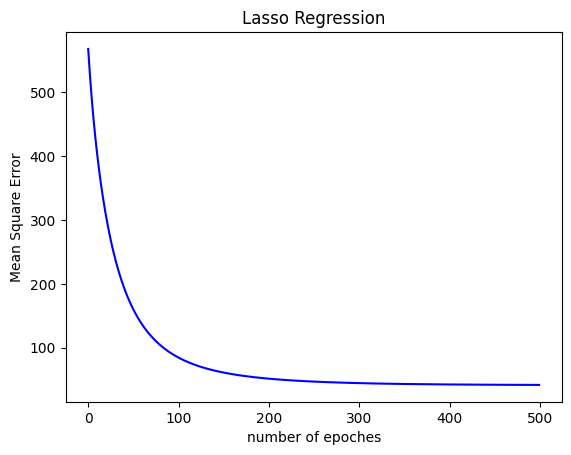

In [ ]:
import matplotlib.pyplot as plt

op = OptimizerLas(lr=0.001, annealing_rate=0.99, batch_size=30, max_epochs=500, lambda_reg = 0.1)

w, errors = LASSO_gd(data_wb, target, op)

plt.title('Lasso Regression')
plt.xlabel('number of epoches')
plt.ylabel("Mean Square Error")
plt.plot(errors, 'b')
plt.show()

Linear regression with SGD

In [ ]:
# solve linear regression using gradient descent
class OptimizerLin():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs

# X[N,d]: input features; y[N]: output targets; op: hyper-parameters for optimzer
def linear_regression_gd(X, y, op):
  n = X.shape[0]   # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  errors = np.zeros(op.max_epochs)
  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]

      # vectorization to compute gradients for a whole mini-batch (see the above formula)
      w_grad = X_batch.T @ X_batch @ w - X_batch.T @ y_batch

      w -= lr * w_grad / X_batch.shape[0]

    diff = X @ w - y  # prediction difference
    errors[epoch] = np.sum(diff*diff)/n
    lr *= op.annealing_rate
    print(f'epoch={epoch}: the mean square error is {errors[epoch]}')

  return w, errors

Displaying the MSE and accuracy (The graph is at the bottom)

epoch=0: the mean square error is 568.0955807616506
epoch=1: the mean square error is 545.9897873025645
epoch=2: the mean square error is 525.528701066773
epoch=3: the mean square error is 506.60768970735444
epoch=4: the mean square error is 488.89512346722717
epoch=5: the mean square error is 472.2719126241246
epoch=6: the mean square error is 456.68085576507406
epoch=7: the mean square error is 441.96516883213764
epoch=8: the mean square error is 428.0496364849433
epoch=9: the mean square error is 414.85634100250104
epoch=10: the mean square error is 402.33534750704894
epoch=11: the mean square error is 390.37446272944607
epoch=12: the mean square error is 378.99412419189906
epoch=13: the mean square error is 368.1170778753218
epoch=14: the mean square error is 357.75635795735684
epoch=15: the mean square error is 347.83720972418035
epoch=16: the mean square error is 338.3264055121851
epoch=17: the mean square error is 329.20972747588604
epoch=18: the mean square error is 320.4688489

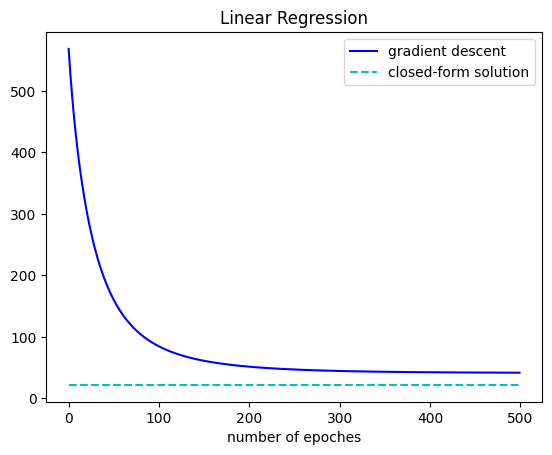

In [ ]:
import matplotlib.pyplot as plt

op = OptimizerLin(lr=0.001, annealing_rate=0.99, batch_size=30, max_epochs=500)

w, errors = linear_regression_gd(data_wb, target, op)

plt.title('Linear Regression')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['gradient descent', 'closed-form solution'])

Comparing Lasso with Linear regression.

Displaying the MSE and accuracy (The graph is at the bottom)

epoch=0: the mean square error is 568.1701308411239
epoch=1: the mean square error is 545.9897846584478
epoch=2: the mean square error is 525.522562031556
epoch=3: the mean square error is 506.57477058433597
epoch=4: the mean square error is 488.8709209429648
epoch=5: the mean square error is 472.23332103340084
epoch=6: the mean square error is 456.5710086704728
epoch=7: the mean square error is 441.89947375762404
epoch=8: the mean square error is 427.9697393482149
epoch=9: the mean square error is 414.80124412076674
epoch=10: the mean square error is 402.26001302391444
epoch=11: the mean square error is 390.3152742331908
epoch=12: the mean square error is 378.94598687740125
epoch=13: the mean square error is 368.10993638202365
epoch=14: the mean square error is 357.7435704330813
epoch=15: the mean square error is 347.8457121027405
epoch=16: the mean square error is 338.3066959428887
epoch=17: the mean square error is 329.1825318222599
epoch=18: the mean square error is 320.45955725802

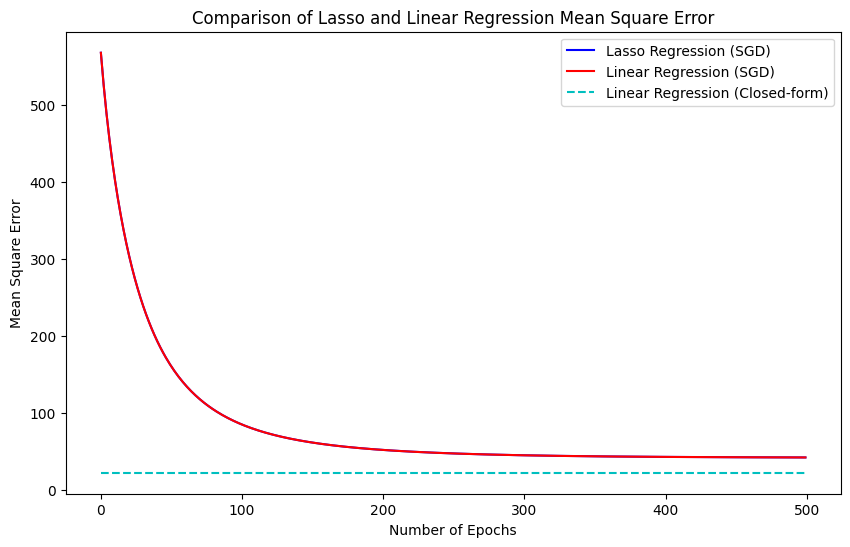

In [ ]:
op_lasso = OptimizerLas(lr=0.001, annealing_rate=0.99, batch_size=30, max_epochs=500, lambda_reg=0.1)
op_linear = OptimizerLin(lr=0.001, annealing_rate=0.99, batch_size=30, max_epochs=500)

w_lasso, errors_lasso = LASSO_gd(data_wb, target, op_lasso)
w_linear, errors_linear = linear_regression_gd(data_wb, target, op_linear)

plt.figure(figsize=(10, 6))
plt.plot(errors_lasso, 'b', label='Lasso Regression (SGD)')
plt.plot(errors_linear, 'r', label='Linear Regression (SGD)')
plt.plot(21.89 * np.ones(errors_linear.shape[0]), 'c--', label='Linear Regression (Closed-form)')
plt.title('Comparison of Lasso and Linear Regression Mean Square Error')
plt.xlabel('Number of Epochs')
plt.ylabel('Mean Square Error')
plt.legend()

plt.show()

**My findings:**

When comparing Lasso and linear regression on the Boston Housing dataset, both models show a steady decrease in mean square error (MSE) over the epochs, with similar MSE trends in the graphs. However, based on the print statements during training, linear regression achieves a slightly lower MSE than Lasso.